In [1]:
import pandas as pd

# Load the dataset
file_path = '/content/sample_data/california_housing_test.csv'
data = pd.read_csv(file_path)

# Display the header
print(data.head())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.05     37.37                27.0       3885.0           661.0   
1    -118.30     34.26                43.0       1510.0           310.0   
2    -117.81     33.78                27.0       3589.0           507.0   
3    -118.36     33.82                28.0         67.0            15.0   
4    -119.67     36.33                19.0       1241.0           244.0   

   population  households  median_income  median_house_value  
0      1537.0       606.0         6.6085            344700.0  
1       809.0       277.0         3.5990            176500.0  
2      1484.0       495.0         5.7934            270500.0  
3        49.0        11.0         6.1359            330000.0  
4       850.0       237.0         2.9375             81700.0  


In [2]:
data.shape

(3000, 9)

In [3]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause t

Selected features: [0, 1, 3, 4, 5, 7]


<Figure size 1000x600 with 0 Axes>

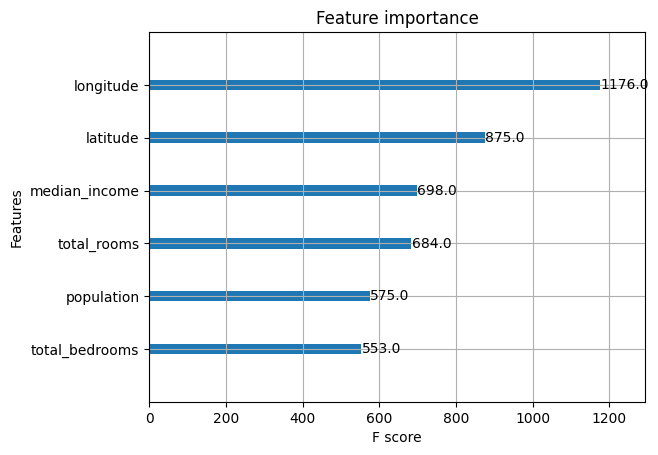

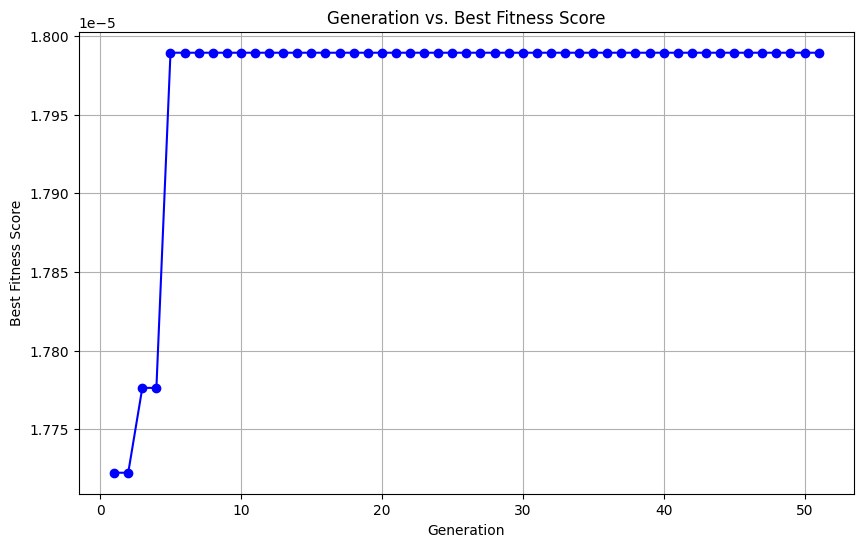

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pygad
import pygad.nn
import pygad.gann
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/sample_data/california_housing_test.csv')

# Separate features and target
X = data.drop(columns=['median_house_value'])
y = data['median_house_value']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the fitness function for GA
def fitness_func(ga_instance, solution, solution_idx):
    # Get the indices of the selected features (where solution == 1)
    selected_features = [index for index in range(len(solution)) if solution[index] == 1]

    # If no feature is selected, return a low fitness score
    if len(selected_features) == 0:
        return 1e-6

    # Filter the selected features for training and testing
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Train the XGBoost Regressor
    model = XGBRegressor()
    model.fit(X_train_selected, y_train)

    # Predict on the test set and calculate RMSE
    predictions = model.predict(X_test_selected)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # The lower the RMSE, the higher the fitness score
    return 1.0 / (rmse + 1e-6)

# Set the parameters for the GA
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=X.shape[1],
    init_range_low=0,
    init_range_high=2,
    mutation_percent_genes=10,
    gene_space=[0, 1],
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    keep_parents=2
)

# Run the GA to optimize feature selection
ga_instance.run()

# Extract the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
selected_features = [index for index in range(len(solution)) if solution[index] == 1]

print(f"Selected features: {selected_features}")

# Train the final model with the selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
final_model = XGBRegressor()
final_model.fit(X_train_selected, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(final_model)
plt.show()

# Plot generation vs best fitness score
generations = list(range(1, len(ga_instance.best_solutions_fitness) + 1))
best_solutions_fitness = ga_instance.best_solutions_fitness

plt.figure(figsize=(10, 6))
plt.plot(generations, best_solutions_fitness, marker='o', linestyle='-', color='b')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Generation vs. Best Fitness Score')
plt.grid()
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Evaluate the model
predictions = final_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f"Final Model RMSE: {rmse}")
print(f"Final Model R^2 Score: {r2}")



Final Model RMSE: 55588.52569765731
Final Model R^2 Score: 0.7546291140422869


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause t

Selected features: [0, 1, 3, 4, 7]
Final Model Accuracy: 0.8266666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73       117
           1       0.84      0.91      0.87       389
           2       0.81      0.67      0.73        94

    accuracy                           0.83       600
   macro avg       0.81      0.75      0.78       600
weighted avg       0.82      0.83      0.82       600



<Figure size 1000x600 with 0 Axes>

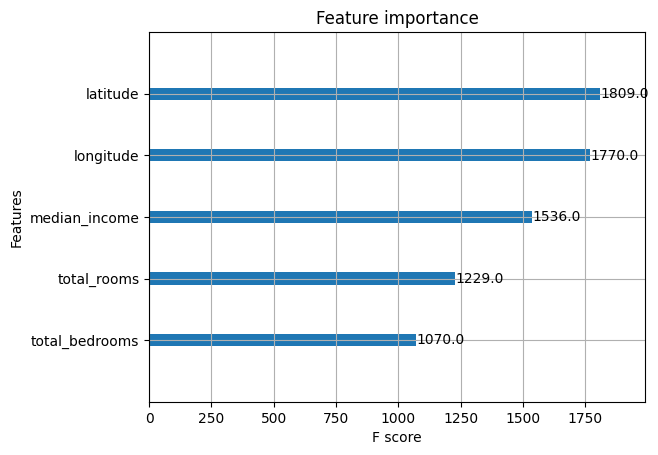

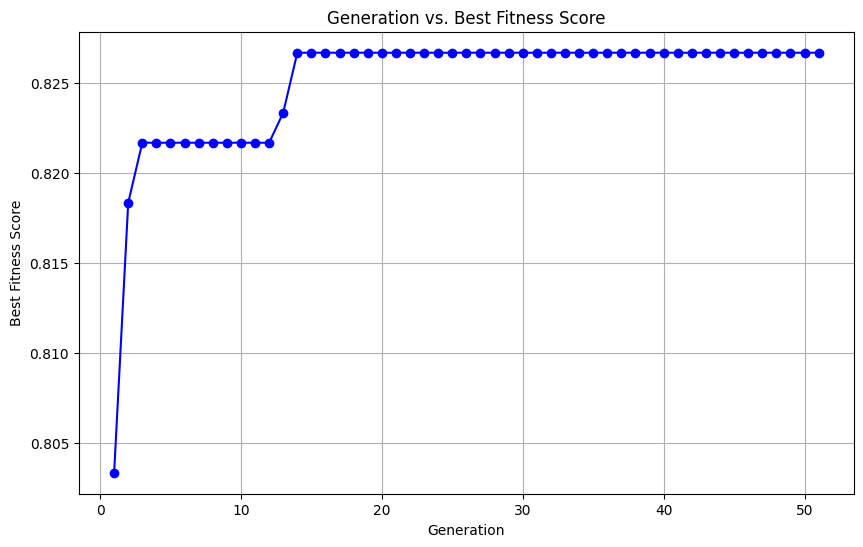

In [12]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pygad
import pygad.nn
import pygad.gann
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/sample_data/california_housing_test.csv')

# Convert the target variable to a classification problem
# Here we categorize the median house value into 3 classes: Low, Medium, High
bins = [0, 100000, 300000, np.inf]
labels = [0, 1, 2]  # 0: Low, 1: Medium, 2: High
y = pd.cut(data['median_house_value'], bins=bins, labels=labels).astype(int)

# Separate features
X = data.drop(columns=['median_house_value'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the fitness function for GA
def fitness_func(ga_instance, solution, solution_idx):
    # Get the indices of the selected features (where solution == 1)
    selected_features = [index for index in range(len(solution)) if solution[index] == 1]

    # If no feature is selected, return a low fitness score
    if len(selected_features) == 0:
        return 1e-6

    # Filter the selected features for training and testing
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Train the XGBoost Classifier
    model = XGBClassifier()
    model.fit(X_train_selected, y_train)

    # Predict on the test set and calculate accuracy
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)

    # The higher the accuracy, the higher the fitness score
    return accuracy

# Set the parameters for the GA
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=X.shape[1],
    init_range_low=0,
    init_range_high=2,
    mutation_percent_genes=10,
    gene_space=[0, 1],
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    keep_parents=2
)

# Run the GA to optimize feature selection
ga_instance.run()

# Extract the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
selected_features = [index for index in range(len(solution)) if solution[index] == 1]

print(f"Selected features: {selected_features}")

# Train the final model with the selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
final_model = XGBClassifier()
final_model.fit(X_train_selected, y_train)

# Evaluate the model
predictions = final_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, predictions)
print(f"Final Model Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, predictions))

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(final_model)
plt.show()

# Plot generation vs best fitness score
generations = list(range(1, len(ga_instance.best_solutions_fitness) + 1))
best_solutions_fitness = ga_instance.best_solutions_fitness

plt.figure(figsize=(10, 6))
plt.plot(generations, best_solutions_fitness, marker='o', linestyle='-', color='b')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Generation vs. Best Fitness Score')
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Selected features: [0, 1, 3, 4, 5, 7]


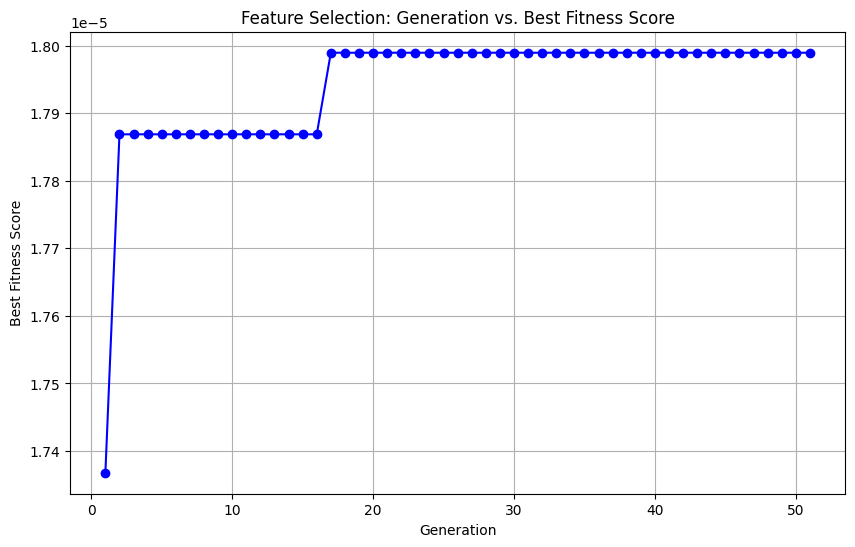

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best Hyperparameters: max_depth=3, learning_rate=0.16259976645157803, n_estimators=158


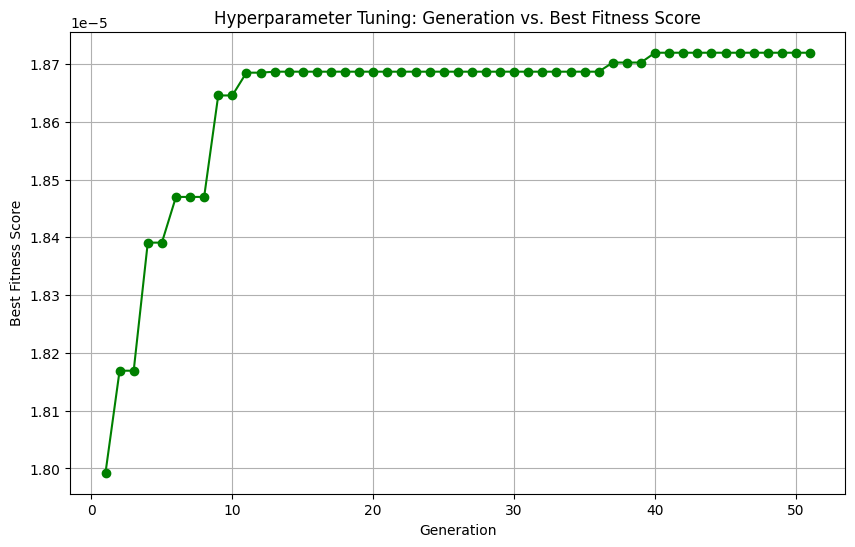

Final Model RMSE: 53419.69093064678
Final Model R^2 Score: 0.7734023189401834


<Figure size 1000x600 with 0 Axes>

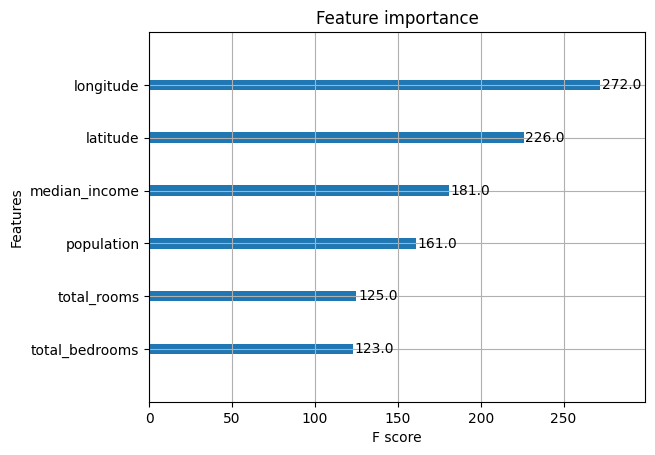

In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pygad
import pygad.nn
import pygad.gann
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/sample_data/california_housing_test.csv')

# Separate features and target
X = data.drop(columns=['median_house_value'])
y = data['median_house_value']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Feature Selection using GA
# Define the fitness function for feature selection
def feature_selection_fitness_func(ga_instance, solution, solution_idx):
    # Get the indices of the selected features (where solution == 1)
    selected_features = [index for index in range(len(solution)) if solution[index] == 1]

    # If no feature is selected, return a low fitness score
    if len(selected_features) == 0:
        return 1e-6

    # Filter the selected features for training and testing
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Train the XGBoost Regressor
    model = XGBRegressor()
    model.fit(X_train_selected, y_train)

    # Predict on the test set and calculate RMSE
    predictions = model.predict(X_test_selected)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # The lower the RMSE, the higher the fitness score
    return 1.0 / (rmse + 1e-6)

# Set the parameters for the GA for feature selection
feature_ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=5,
    fitness_func=feature_selection_fitness_func,
    sol_per_pop=10,
    num_genes=X.shape[1],
    gene_space=[0, 1],
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    keep_parents=2
)

# Run the GA to optimize feature selection
feature_ga_instance.run()

# Extract the best solution for feature selection
feature_solution, feature_solution_fitness, feature_solution_idx = feature_ga_instance.best_solution()
selected_features = [index for index in range(len(feature_solution)) if feature_solution[index] == 1]

print(f"Selected features: {selected_features}")

# Plot generation vs best fitness score for feature selection
generations = list(range(1, len(feature_ga_instance.best_solutions_fitness) + 1))
best_solutions_fitness = feature_ga_instance.best_solutions_fitness

plt.figure(figsize=(10, 6))
plt.plot(generations, best_solutions_fitness, marker='o', linestyle='-', color='b')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Feature Selection: Generation vs. Best Fitness Score')
plt.grid()
plt.show()

# Step 2: Hyperparameter Tuning using GA
# Filter the selected features for training and testing
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Define the fitness function for hyperparameter tuning
def hyperparameter_tuning_fitness_func(ga_instance, solution, solution_idx):
    # Extract hyperparameters from the solution
    max_depth = int(solution[0])
    learning_rate = solution[1]
    n_estimators = int(solution[2])

    # Train the XGBoost Regressor with extracted hyperparameters
    model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
    model.fit(X_train_selected, y_train)

    # Predict on the test set and calculate RMSE
    predictions = model.predict(X_test_selected)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # The lower the RMSE, the higher the fitness score
    return 1.0 / (rmse + 1e-6)

# Set the parameters for the GA for hyperparameter tuning
hyperparameter_ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=5,
    fitness_func=hyperparameter_tuning_fitness_func,
    sol_per_pop=10,
    num_genes=3,  # 3 hyperparameters
    gene_space=[{'low': 3, 'high': 10}, {'low': 0.01, 'high': 0.3}, {'low': 50, 'high': 200}],
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    keep_parents=2
)

# Run the GA to optimize hyperparameters
hyperparameter_ga_instance.run()

# Extract the best solution for hyperparameter tuning
hyperparameter_solution, hyperparameter_solution_fitness, hyperparameter_solution_idx = hyperparameter_ga_instance.best_solution()
max_depth = int(hyperparameter_solution[0])
learning_rate = hyperparameter_solution[1]
n_estimators = int(hyperparameter_solution[2])

print(f"Best Hyperparameters: max_depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}")

# Plot generation vs best fitness score for hyperparameter tuning
generations = list(range(1, len(hyperparameter_ga_instance.best_solutions_fitness) + 1))
best_solutions_fitness = hyperparameter_ga_instance.best_solutions_fitness

plt.figure(figsize=(10, 6))
plt.plot(generations, best_solutions_fitness, marker='o', linestyle='-', color='g')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Hyperparameter Tuning: Generation vs. Best Fitness Score')
plt.grid()
plt.show()

# Train the final model with the selected features and hyperparameters
final_model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
final_model.fit(X_train_selected, y_train)

# Evaluate the model
predictions = final_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f"Final Model RMSE: {rmse}")
print(f"Final Model R^2 Score: {r2}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(final_model)
plt.show()
